# Piezo-electro sensor

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
from matplotlib import pyplot as plt

In [2]:
def force(t, omega):
    '''
    This function computes the force with which the piezo-electro sensor is stimulated.
    It is a harmonic force of amplitude 1 and angular frequency omega.

    Parameters:
    -----------
    t: time [s]
    omega: angular frequency [s^-1]

    Returns:
    --------
    (float) sin(omega*t)
    '''
    return np.sin(omega*t)

def q_vector_derivative(t, q_vector, omega, omega_0, xi, d):
    '''
    This function 

    Parameters:
    -----------
    t: time [s]
    q_vector: numpy array of the form (q,q'), where q is the charge [C]
    omega: angular frequency of force [s^-1]
    omega_0: natural frequency of the system [s^-1]
    xi: damping factor of the system [dimensionless]
    d: charge sensitivity parameter [C/N]

    Returns:
    --------
    (numpy array) derivative of [q,q']
    '''

    q0 = q_vector[0]
    q1 = q_vector[1]
    q0_d = q1
    q1_d = d * omega_0**2 * force(t, omega) - 2 * xi * omega_0 * q1 - omega_0**2 * q0

    return np.array([q0_d, q1_d])

def solve_differential_equation(time_points, initial_condition, omega, omega_0=1, xi=1, d=1, alpha=0):
    '''
    Solve the differential equation q_vector(t)' = q_vector_derivative(t, omega, omega_0, xi, d, alpha)
    
    Parameters:
    ------------
    time_points: array-like sequence of time instants where to solve the equation
    inital_condition: array with the inistal condition [q_init, q_init']
    omega: angular frequency of force [s^-1]
    omega_0: natural frequency of the system [s^-1]
    xi: damping factor of the system [dimensionless]
    d: charge sensitivity parameter [C/N]
    alpha: non-linear factor [N^-2]

    Returns:
    --------
    (time_points, q_vector_solution)
    '''

    ode_solution = solve_ivp(q_vector_derivative, (time_points[0], time_points[-1]),
                             initial_condition, t_eval=time_points,
                             args=(omega, omega_0, xi, d))
                            
    return (ode_solution.t, ode_solution.y)

In [7]:
time_points = np.linspace(0, 100, 1000)
initial_condition = np.array([0,0])

t, qv = solve_differential_equation(time_points, initial_condition, 1)

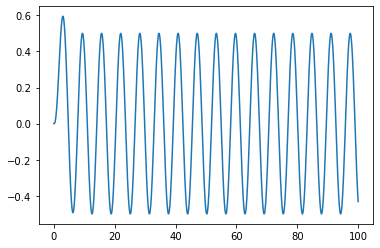

In [8]:
plt.plot(t, qv[0])